<a href="https://colab.research.google.com/github/petersenmatthew/ai-skill-showcase/blob/feature%2Fmatthew/matthew_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# import libs
import os
import matplotlib.pyplot as plt
import numpy as np

# pytorch libs
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

In [3]:
from google.colab import files
import zipfile

# Upload the 400MB zip file manually
uploaded = files.upload()  # Select sports-ball-dataset.zip

# Unzip the dataset
with zipfile.ZipFile("sports-ball-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

Saving sports-ball-dataset.zip to sports-ball-dataset.zip


In [15]:
# Check what got unzipped
print("Root contents:", os.listdir("/content"))

# Check train and test folders
print("Train folder:", os.listdir("/content/train")[:10])  # show first 10
print("Test folder:", os.listdir("/content/test")[:10])

Root contents: ['.config', 'train', 'test', 'sports-ball-dataset.zip', 'sample_data']
Train folder: ['cricket_ball', 'hockey_puck', 'hockey_ball', 'basketball', 'table_tennis_ball', 'football', 'golf_ball', 'shuttlecock', 'volleyball', 'baseball']
Test folder: ['cricket_ball', 'hockey_puck', 'hockey_ball', 'basketball', 'table_tennis_ball', 'football', 'golf_ball', 'shuttlecock', 'volleyball', 'baseball']


In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # resize to 128x128
    transforms.ToTensor(),           # convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1,1]
])

train_data = datasets.ImageFolder(root="/content/train", transform=transform)
test_data = datasets.ImageFolder(root="/content/test", transform=transform)

print(f"Classes: {train_data.classes}")
print(f"Train size: {len(train_data)} | Test size: {len(test_data)}")


Classes: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']
Train size: 7328 | Test size: 1841


In [17]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 229, Test batches: 58


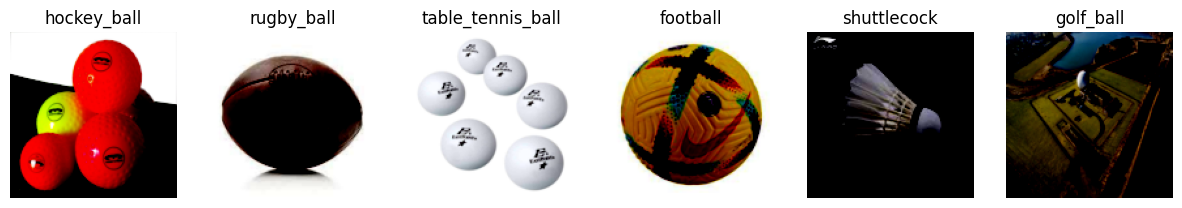

In [29]:
images, labels = next(iter(train_loader)) # get batches of images + labels, grab first batch

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(images[i].permute(1, 2, 0))  # convert from (channels, height, width) to (height, width, channels) - pytorch vs matplotlib
    axes[i].set_title(train_data.classes[labels[i]]) # set label
    axes[i].axis("off")
plt.show()

In [30]:
#build CNN
# learn edges, shapes, textures

class BallClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(BallClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # take input with 3 channels (RGB) - learns 32 filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # reduce image size by half each time
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*32*32)  # convert feature maps into a 1D vector - for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BallClassifier(num_classes=len(train_data.classes)).to(device)
print(model)

BallClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)


In [31]:
# define loss range and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)